In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
from torchvision import transforms
from Classifier import Classifier
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision import datasets, transforms ## 导入数据集与数据预处理的方法


def getImageTensor(image):
    imagel = image.convert('L')
    # %%
    # 将图片转换为1X28X28的tensor
    transform = transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
    image_tensor = transform(imagel)
    img = image_tensor.reshape((28, 28)).numpy()
    img = torch.from_numpy(img)
    img = img.view(1, 784)
    plt.imshow(img)
    # image_tensor = image_tensor.unsqueeze(0)  # 增加批次维度

    # print("调整后图像的形状",image_tensor.shape)
    # %%
    # 将图像的tensor转换为新的尺寸的灰度图像
    # to_pil = transforms.ToPILImage()
    # gray_image = to_pil(image_tensor.cpu().squeeze(0))
    # print("调整后的灰度图像", gray_image)
    # gray_image.show()
    return img



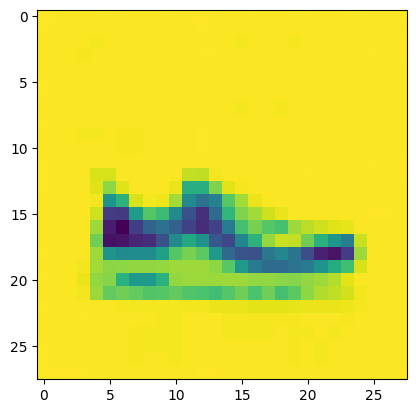

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
image = Image.open('images/shoes2.jpg')
imagel = image.convert('L')
transform = transforms.Compose([transforms.Resize((28, 28)),  # 调整图片大小为 28x28 像素
                                    transforms.Grayscale(),  # 转换为灰度图
                                    transforms.ToTensor(),  # 将 PIL 图片转换为 Tensor
                                    transforms.Normalize((0.5,), (0.5,))]) # 归一化
image_tensor = transform(image).unsqueeze(0)
img = image_tensor.reshape((28, 28)).numpy()

# 使用 plt.imshow() 显示图像
plt.imshow(img)  # 使用灰度颜色映射
plt.show()

In [49]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# 下载Fashion-MNIST训练集数据，并构建训练集数据载入器trainloader,每次从训练集中载入64张图片，每次载入都打乱顺序
trainset = datasets.FashionMNIST('dataset/', download=False, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# 下载Fashion-MNIST测试集数据，并构建测试集数据载入器trainloader,每次从测试集中载入64张图片，每次载入都打乱顺序
testset = datasets.FashionMNIST('dataset/', download=False, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

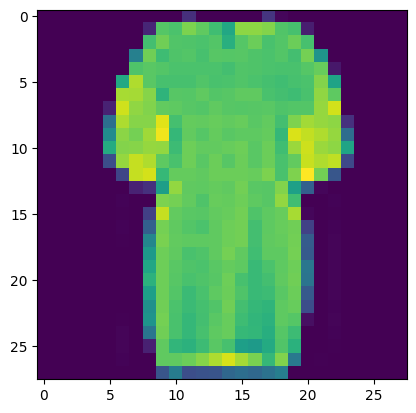

In [50]:
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]
img = img.reshape((28,28)).numpy()
plt.imshow(img)
plt.show()

In [29]:
#加载模型
def predict(images_tensor,predictions=[],probabilitys = []):
    model_load = torch.load("model.pt", map_location=torch.device('cuda'), weights_only=True)
    model = Classifier()
    model.load_state_dict(model_load)
    model.eval()
    for image_tensor in images_tensor:
        with torch.no_grad():
            output = model.forward(image_tensor)
        ps = torch.exp(output)

        top_p, top_class = ps.topk(1, dim=1)
        labellist = ['T恤', '裤子', '套衫', '裙子', '外套', '凉鞋', '汗衫', '运动鞋', '包包', '靴子']
        print(top_class)
        prediction = labellist[top_class]
        probability = float(top_p)
        predictions.append(prediction)
        probabilitys.append(probability)
        print(f'神经网络猜测图片里是 {prediction}，概率为{probability * 100}%')
    return predictions,probabilitys

In [51]:
img = torch.from_numpy(img)
img = img.view(1, 784)

model_load = torch.load("model.pt", map_location=torch.device('cuda'), weights_only=True)
model = Classifier()
model.load_state_dict(model_load)
model.eval()
# 进行正向推断，预测图片所在的类别
with torch.no_grad():
    output = model.forward(img)
ps = torch.exp(output)

top_p, top_class = ps.topk(1, dim=1)
labellist = ['T恤','裤子','套衫','裙子','外套','凉鞋','汗衫','运动鞋','包包','靴子']
prediction = labellist[top_class]
probability = float(top_p)
print(f'神经网络猜测图片里是 {prediction}，概率为{probability*100}%')

RuntimeError: Error(s) in loading state_dict for Classifier:
	Missing key(s) in state_dict: "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias", "fc3.weight", "fc3.bias", "fc4.weight", "fc4.bias". 
	Unexpected key(s) in state_dict: "conv1.0.weight", "conv1.0.bias", "conv1.1.weight", "conv1.1.bias", "conv1.1.running_mean", "conv1.1.running_var", "conv1.1.num_batches_tracked", "conv2.0.weight", "conv2.0.bias", "conv2.1.weight", "conv2.1.bias", "conv2.1.running_mean", "conv2.1.running_var", "conv2.1.num_batches_tracked", "conv3.0.weight", "conv3.0.bias", "conv3.1.weight", "conv3.1.bias", "conv3.1.running_mean", "conv3.1.running_var", "conv3.1.num_batches_tracked", "fc.weight", "fc.bias". 

In [47]:
def DrawImage(image,prediction,probability):

    draw = ImageDraw.Draw(image)
    position = (50, 50)  # 文字位置
    font = ImageFont.truetype(font='arial.ttf', size=10)
    text_color = (255, 0, 0)  # 设置文本颜色，这里设置为红色
    text = f'The neural network guesses that the image is a {prediction} with a probability of {probability * 100}%.'  # 文字内容
    draw.text(position, text, font=font, fill=text_color)
    image.save('example_with_text.jpg')


import os
from PIL import Image

# 设置文件夹路径
folder_path = 'images'
images_tensor = []

# 遍历文件夹中的所有文件
for filename in os.listdir(folder_path):
    # 检查文件是否是图片（这里以.jpg和.png为例）
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # 构建完整的文件路径
        file_path = os.path.join(folder_path, filename)
        # 打开图片
        with Image.open(file_path) as img:
            image_tensor = getImageTensor(img)
            images_tensor.append(image_tensor)
            # DrawImage(img,prediction,probability)

predict(images_tensor)





tensor([[0]])
神经网络猜测图片里是 T恤，概率为99.93866682052612%
tensor([[4]])
神经网络猜测图片里是 外套，概率为99.89709854125977%
tensor([[6]])
神经网络猜测图片里是 汗衫，概率为48.851656913757324%
tensor([[6]])
神经网络猜测图片里是 汗衫，概率为54.38600778579712%
tensor([[6]])
神经网络猜测图片里是 汗衫，概率为54.38600778579712%
tensor([[6]])
神经网络猜测图片里是 汗衫，概率为54.38600778579712%
tensor([[7]])
神经网络猜测图片里是 运动鞋，概率为100.0%


(['T恤', '外套', '汗衫', '汗衫', '汗衫', '汗衫', '运动鞋'],
 [0.9993866682052612,
  0.9989709854125977,
  0.48851656913757324,
  0.5438600778579712,
  0.5438600778579712,
  0.5438600778579712,
  1.0])